# Utility Software : Compression

Utility Software that compresses is almost always **Lossless** as you need to get the files back exactly like there orginal.

## When is lossy compression useful?


Double click here to edit

Press "Shift + Enter" to process a box and move on to the next bit. 

## Set up

Use "Shift + Enter" to run the next 2 blocks, this will get everything we need set up.


In [2]:
# Install 2 python libraries
import micropip
await micropip.install(["python-rle", "pycountry"]) # Install required libraries

In [3]:
# Import libraries
import rle
from js import fetch
import json
from PIL import Image, ImageDraw
import numpy as np
import pycountry
import sys

class NpEncoder(json.JSONEncoder):
    """Work around for numpy to JSON"""
    def default(self, obj):
        if isinstance(obj, np.bool_):
            return bool(obj)
        if isinstance(obj, (np.floating, np.complexfloating)):
            return float(obj)
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, np.string_):
            return str(obj)
        return super(NpEncoder, self).default(obj)
         
async def load_file_into_in_mem_filesystem(url, fn=None):
    """Load a file from a URL into an in-memory filesystem."""
    # Create a filename if required
    fn = fn if fn is not None else url.split("/")[-1]
    # Fetch file from URL
    res = await fetch(url)
    # Buffer it
    buffer = await res.arrayBuffer()
    # Write file to in-memory file system
    open(fn, "wb").write(bytes(buffer.valueOf().to_py()))
 
    return fn


async def fetch_flag(text):
    """Get a flag from the web by eith 2 letter code or searching for that code using the text """
    if (len(text) > 2):
        code = pycountry.countries.search_fuzzy(text)[0].alpha_2
    code = code.lower()
    url = "https://raw.githubusercontent.com/hampusborgos/country-flags/main/png100px/"+code+".png"
    print(url)
    flag_file = await load_file_into_in_mem_filesystem(url)
    return flag_file


def compress_VertRleOfHoriRle(dat):
    """Compress dat by doing a run length encoding up the column after they been RLEd along the rows already
    Return string"""
    lines = []
    for x in dat:
        x_rle = rle.encode(x.tolist())
        lines.append(x_rle)
    out = rle.encode(lines)
    return json.dumps(out, cls=NpEncoder, separators=(',', ':'))

def decompress_VertRleOfHoriRle(text):
    """Decode the RLE Vertically first, the horizontally creating a grid of pixels"""
    comp = json.loads(text)
    out = [rle.decode(x[0], x[1]) for x in rle.decode(comp[0], comp[1])]
    return out

def compress_HoriRleOfVertRle(dat):
    """Compress dat by doing a run length encoding along the row after they been RLEd up the columns already
    Return String"""
    cols = []
    for col in dat.T:
        cols.append(rle.encode(col.tolist()))
    out = rle.encode(cols)
    return json.dumps(out, cls=NpEncoder, separators=(',', ':'))

def decompress_HoriRleOfVertRle(text):
    """Decode the RLE Horizontally first, placing it in a grid"""
    comp = json.loads(text)
    dat = []
    cols = rle.decode(comp[0], comp[1])
    for x in range(len(cols)):
        col = rle.decode(cols[x][0], cols[x][1])
        for y in range(len(col)):
            if x == 0:
                dat.append([])
            dat[y].append(col[y])
    return  dat

def createImage(data, palette):
    image = Image.new("P", (len(data[0]), len(data)))
    image.putpalette(palette)
    for x in range(image.width):
        for y in range(image.height):
            image.putpixel((x,y), data[y][x])
    return image

# rle-encode.py

def rle_encode(data):
    encoding = ''
    prev_char = ''
    count = 1

    if not data: return ''

    for char in data:
        # If the prev and current characters
        # don't match...
        if char != prev_char:
            # ...then add the count and character
            # to our encoding
            if prev_char:
                encoding += str(count) + prev_char
            count = 1
            prev_char = char
        else:
            # Or increment our counter
            # if the characters do match
            count += 1
    else:
        # Finish off the encoding
        encoding += str(count) + prev_char
        return encoding

# rle-decode.py

def rle_decode(data):
    decode = ''
    count = ''
    for char in data:
        # If the character is numerical...
        if char.isdigit():
            # ...append it to our count
            count += char
        else:
            # Otherwise we've seen a non-numerical
            # character and need to expand it for
            # the decoding
            decode += char * int(count)
            count = ''
    return decode

def rle_results(plain_text): 
    encoded = rle_encode(plain_text)
    decoded = rle_decode(encoded)
    print("Original =", plain_text, "Orginal Length", len(plain_text), "bytes (assuming ASCII)")
    print("Encoded  =", encoded, "Encoded Length", len(encoded), "bytes (assuming ASCII)")
    print("Decoded  =", decoded)

async def flags_rle_results(country_name, debug = False):

    file_name = await fetch_flag(country_name)
    print("country_name= ", country_name, "file_name =", file_name)

    im = Image.open(file_name)
    im2 = im.quantize(dither = Image.Dither.NONE)

    display(im2) # Show the image
    palette = im2.getpalette() 
    dat = np.asarray(im2)
    print("Size of original image approx", (im2.width * im2.height) + len(palette), "bytes") 

    HVtext = compress_HoriRleOfVertRle(dat)
    print("HoriRleOfVertRle", "length =", len(HVtext), "bytes")
    if debug:
        print( "HVtext =", HVtext)
    uncompressed = decompress_HoriRleOfVertRle(HVtext)
    #im3 = createImage(decompress_HoriRleOfVertRle(HVtext), im2.getpalette())
    #display(im3)

    VHtext = compress_VertRleOfHoriRle(dat)
    print("HoriRleOfVertRle", "length =", len(VHtext), "bytes")
    if debug:
        print( "VHtext =", VHtext)
    im4 = createImage(decompress_VertRleOfHoriRle(VHtext), im2.getpalette())
    #display(im4)
    

## Simple Compression : Run Length Encoding 

Steps :
1. Get Text
2. Start on left
3. Get next letter
4. How many of this letter next are next to each other (the run)?
5. Write down the Run Length and the Letter
6. Go To 3

### Task : 
Follow the instructions and fill in ```hand_encoded="1A"``` The first run is done for you.

Once you have it correct "Shift + Enter" will run it



In [4]:
plain_text = "ABBCCCDDDEEEEFFFFFGGGGGG"

# TODO : Complete this Run Length encoded string by hand
hand_encoded = "1A"

encoded = rle_encode(plain_text)
assert hand_encoded == encoded, "That's not quite right" 
encoded

<class 'AssertionError'>: That's not quite right

#### Evidence

In [5]:
rle_decode(encoded)

'ABBCCCDDDEEEEFFFFFGGGGGG'

#### Is it any good?

In [6]:
plain_text = "ABBCCCDDDEEEEFFFFFGGGGGG"
rle_results(plain_text)

plain_text = "Our Deepest Fear Is Not That We Are Inadequate. Our Deepest Fear Is That We Are Powerful Beyond Measure"
rle_results(plain_text)

Original = ABBCCCDDDEEEEFFFFFGGGGGG Orginal Length 24 bytes (assuming ASCII)
Encoded  = 1A2B3C3D4E5F6G Encoded Length 14 bytes (assuming ASCII)
Decoded  = ABBCCCDDDEEEEFFFFFGGGGGG
Original = Our Deepest Fear Is Not That We Are Inadequate. Our Deepest Fear Is That We Are Powerful Beyond Measure Orginal Length 103 bytes (assuming ASCII)
Encoded  = 1O1u1r1 1D2e1p1e1s1t1 1F1e1a1r1 1I1s1 1N1o1t1 1T1h1a1t1 1W1e1 1A1r1e1 1I1n1a1d1e1q1u1a1t1e1.1 1O1u1r1 1D2e1p1e1s1t1 1F1e1a1r1 1I1s1 1T1h1a1t1 1W1e1 1A1r1e1 1P1o1w1e1r1f1u1l1 1B1e1y1o1n1d1 1M1e1a1s1u1r1e Encoded Length 202 bytes (assuming ASCII)
Decoded  = Our Deepest Fear Is Not That We Are Inadequate. Our Deepest Fear Is That We Are Powerful Beyond Measure


### Is Run Length Encoding Good for Text?

Double Click and answer here.

## Loading an Image

https://raw.githubusercontent.com/hampusborgos/country-flags/main/png100px/de.png
file_name = de.png


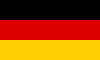

In [7]:
country_name = 'Germany'

file_name = await fetch_flag(country_name)
print("file_name =", file_name)

im = Image.open(file_name)
im2 = im.quantize(dither = Image.Dither.NONE)

im2 # Show the image


## Looking at the data



### Paint by Numbers

In [9]:
palette = im2.getpalette() 
print("Palette", palette[:60])
for colour in range(3):
    print("Colour", colour, "Red =",palette[(colour*3)], "Green =",palette[(colour*3)+1], "Blue =",palette[(colour*3)+2])

dat = np.asarray(im2)

print("The colours in the top row", dat[0]) # Show the data of the bottom row

Palette [255, 206, 0, 221, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Colour 0 Red = 255 Green = 206 Blue = 0
Colour 1 Red = 221 Green = 0 Blue = 0
Colour 2 Red = 0 Green = 0 Blue = 0
The colours in the top row [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [10]:
#np.set_printoptions(threshold=sys.maxsize) # Print every bit
#dat

## Compressing an Image : RLE H of V

Run Length encoding each Column upwards and then RLE those columns again sidewards 

Size of original image approx 6768 bytes
HoriRleOfVertRle length = 30 bytes
HVtext = [[[[2,1,0],[20,20,20]]],[100]]


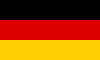

In [11]:
print("Size of original image approx", (im2.width * im2.height) + len(palette), "bytes") 

HVtext = compress_HoriRleOfVertRle(dat)
print("HoriRleOfVertRle", "length =", len(HVtext), "bytes")
print( "HVtext =", HVtext)
uncompressed = decompress_HoriRleOfVertRle(HVtext)
im3 = createImage(decompress_HoriRleOfVertRle(HVtext), im2.getpalette())
im3

- This is compressing to a string representation of Arrays (JSON) (we could use binary to make it even small).
- In the case of Germany  
    - HVtext = [[[[2,1,0],[20,20,20]]],[**100**]] a 100 columns of ..
        - HVtext = [[[[**2**,1,0],[**20**,20,20]]],[100]] 20 pixels of palette colour 2 [0,0,0] Black
        - HVtext = [[[[2,**1**,0],[20,**20**,20]]],[100]] 20 pixels of palette colour 1 [0,221,0] Red
        - HVtext = [[[[2,1,**0**],[20,20,**20**]]],[100]] 20 pixels of palette colour 1 [255, 206, 0] Yellow


## Compressing an Image : RLE V of H

Run Length encoding each row left to right then RLE those together upwards 

HoriRleOfVertRle length = 50 bytes
VHtext = [[[[2],[100]],[[1],[100]],[[0],[100]]],[20,20,20]]


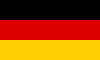

In [12]:
VHtext = compress_VertRleOfHoriRle(dat)
print("HoriRleOfVertRle", "length =", len(VHtext), "bytes")
print( "VHtext =", VHtext)
im4 = createImage(decompress_VertRleOfHoriRle(VHtext), im2.getpalette())
im4

- In the case of Germany  
    - HVtext = [[**[[2],[100]]**,[[1],[100]],[[0],[100]]],[**20**,20,20]] 20 rows of 100 pixels of palette colour 2 [0,0,0] Black
    - HVtext = [[[[2],[100]],**[[1],[100]]**,[[0],[100]]],[20,**20**,20]] 20 rows of 100 pixels of palette colour 1 [0,221,0] Red
    - HVtext = [[[[2],[100]],[[1],[100]],**[[0],[100]]**],[20,20,**20**]] 20 rows of 100 pixels of palette colour 0 [255, 206, 0] Yellow

### Remix Germany


Change the flag around maybe change the size (it might crash don't worry.)

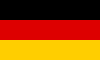

In [13]:
palette = [255, 206, 0, 221, 0, 0, 0, 0, 0]
remix = "[[[[2,1,0],[20,20,20]]],[100]]"
createImage(decompress_HoriRleOfVertRle(remix), palette)

### Is Run Length Encoding Good for Images ?

https://raw.githubusercontent.com/hampusborgos/country-flags/main/png100px/fr.png
country_name=  France file_name = fr.png


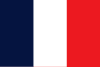

Size of original image approx 7468 bytes
HoriRleOfVertRle length = 89 bytes
HoriRleOfVertRle length = 68 bytes
SubdivisionHierarchy(code='MX-MEX', country_code='MX', name='México', parent_code=None, type='State')
https://raw.githubusercontent.com/hampusborgos/country-flags/main/png100px/mx.png
country_name=  Mexico file_name = mx.png


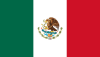

Size of original image approx 6468 bytes
HoriRleOfVertRle length = 2801 bytes
HoriRleOfVertRle length = 3299 bytes
https://raw.githubusercontent.com/hampusborgos/country-flags/main/png100px/ir.png
country_name=  Iran file_name = ir.png


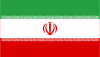

Size of original image approx 6468 bytes
HoriRleOfVertRle length = 5806 bytes
HoriRleOfVertRle length = 3583 bytes
https://raw.githubusercontent.com/hampusborgos/country-flags/main/png100px/br.png
country_name=  Brazil file_name = br.png


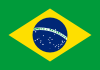

Size of original image approx 7768 bytes
HoriRleOfVertRle length = 6296 bytes
HoriRleOfVertRle length = 5373 bytes
https://raw.githubusercontent.com/hampusborgos/country-flags/main/png100px/gb.png
country_name=  Britain file_name = gb.png


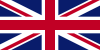

Size of original image approx 5768 bytes
HoriRleOfVertRle length = 7689 bytes
HoriRleOfVertRle length = 5436 bytes
https://raw.githubusercontent.com/hampusborgos/country-flags/main/png100px/af.png
country_name=  Afghanistan file_name = af.png


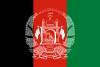

Size of original image approx 7468 bytes
HoriRleOfVertRle length = 11037 bytes
HoriRleOfVertRle length = 11592 bytes
https://raw.githubusercontent.com/hampusborgos/country-flags/main/png100px/pn.png
country_name=  Pitcairn file_name = pn.png


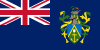

Size of original image approx 5768 bytes
HoriRleOfVertRle length = 9302 bytes
HoriRleOfVertRle length = 8473 bytes


In [14]:
await flags_rle_results(country_name = 'France')
await flags_rle_results(country_name = 'Mexico')
await flags_rle_results(country_name = 'Iran')
await flags_rle_results(country_name = 'Brazil')
await flags_rle_results(country_name = 'Britain')
await flags_rle_results(country_name = 'Afghanistan')
await flags_rle_results(country_name = 'Pitcairn')

### Is Run Length Encoding Good for Images ?

Double Click and answer here.


#### Explain any exceptions to that.

Double Click and answer here.


# Encryption Software


In [1]:
import hashlib


## Save and turn in